## Taxi Forecasting with Pyro

This notebook explores using Pyro to create a probabilistic Seasonal Global Trend (SGT) model. It jumps straight to modelling an hourly seasonality through the day, and extends this to look at seasonality over days in the week.


In [11]:
import math
import torch
import glob
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from collections import defaultdict
import pandas as pd
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints
import matplotlib.pyplot as plt
%matplotlib inline

pyro.enable_validation()
print(pyro.__version__)
print(torch.__version__)

0.4.1
1.2.0


In [6]:
path = r'../data/raw'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [7]:
dates = frame[['tpep_pickup_datetime', 'payment_type']]

In [8]:
dates['tpep_pickup_datetime'] = pd.to_datetime(dates['tpep_pickup_datetime'])
dates = dates.set_index('tpep_pickup_datetime') 
grouped = dates.resample('1h').count()

/Users/james.malcolm/anaconda3/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
grouped = grouped['2018-01-01':'2018-06-30']
grouped.head()

,payment_type
tpep_pickup_datetime,
2018-01-01 00:00:00,16458
2018-01-01 01:00:00,18985
2018-01-01 02:00:00,16561
2018-01-01 03:00:00,12611
2018-01-01 04:00:00,8726


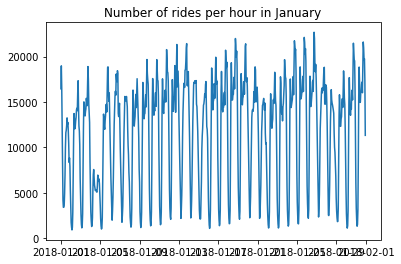

In [13]:
plt.plot(grouped['2018-01'])
plt.title("Number of rides per hour in January");

In [65]:
y = torch.tensor(grouped['payment_type'].values, dtype=torch.float32)
y_log = y.log()

In [90]:
N = len(y)
N_test = 200
N_train = N - N_test
y_train = y[:N_train]

In [91]:
N_train

4144

In [98]:
def model_sgt(y):
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    daily_seasonality = pyro.param('daily_seasonality', torch.zeros(24))
    weekly_seasonality = pyro.param('weekly_seasonality', torch.zeros(24 * 7))
    
    # Get diffs of seasonality factors
    daily_seasonality = daily_seasonality - daily_seasonality.mean()
    weekly_seasonality = weekly_seasonality - weekly_seasonality.mean()
    
    N = len(y)
    
    with pyro.plate('N', N) as t:
        daily_seasonality_factor = daily_seasonality.repeat(math.ceil(N / 24))[:N]
        weekly_seasonality_factor = weekly_seasonality.repeat(math.ceil(N / (24 * 7)))[:N]
        
        log_y_hat = slope * t.type(torch.float) + intercept + daily_seasonality_factor + weekly_seasonality_factor
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

In [99]:
opt = Adam({"lr": 0.08})
pyro.clear_param_store()
empty_guide = lambda x: None
svi = SVI(model_sgt, empty_guide, opt, loss=Trace_ELBO())

for i in range(3000):
    loss = svi.step(y_train)
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 2868907.7374517373
ELBO loss: 11.084049416324808
ELBO loss: 10.96506338229971
ELBO loss: 10.815066775760135
ELBO loss: 10.652582234857626
ELBO loss: 10.49653112934363
ELBO loss: 10.364312484917953


In [100]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()

slope, intercept

(tensor(-0.0004), tensor(10.4642))

In [101]:
time_range = pd.date_range(start='2018-01-01', freq='H', periods=len(y))

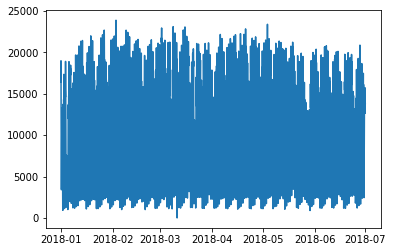

In [102]:
plt.plot(time_range, y)

4344
tensor([-0.0302, -0.4177, -0.8633,  ...,  0.4245,  0.4074,  0.2638])
tensor([-0.6920, -0.8145, -0.7872,  ...,  0.0217,  0.1238,  0.2584])


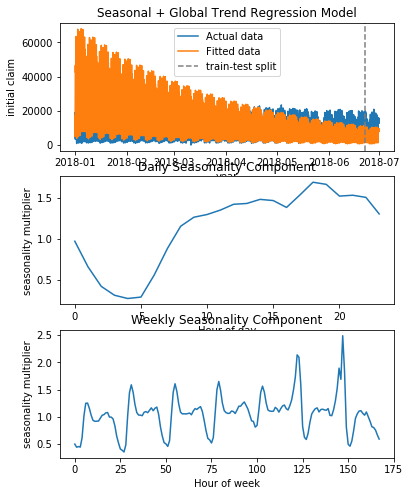

In [103]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()

daily_seas  = pyro.param('daily_seasonality').detach()
daily_seas = (daily_seas - daily_seas.mean())

week_seas  = pyro.param('weekly_seasonality').detach()
week_seas = (week_seas - week_seas.mean())

daily_seasonality_rep = daily_seas.repeat(math.ceil(len(y) / 24))[:len(y)]
week_seasonality_rep = week_seas.repeat(math.ceil(len(y) / (24 * 7)))[:len(y)]
print(len(y))
print(daily_seasonality_rep)
print(week_seasonality_rep)

model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept + daily_seasonality_rep + week_seasonality_rep).exp()

fig, ax = plt.subplots(3, 1, figsize=(6, 8))

ax[0].plot(time_range, y, label='Actual data')
ax[0].plot(time_range, model_fit.detach(), label='Fitted data')
ax[0].set(title='Seasonal + Global Trend Regression Model', 
          xlabel='year',
          ylabel='initial claim')
ax[0].axvline(time_range[N_train], linestyle='--', color='gray', label='train-test split')
ax[0].legend();

ax[1].plot(range(24), daily_seas.exp())
ax[1].set(title='Daily Seasonality Component', 
          xlabel='Hour of day', 
          ylabel='seasonality multiplier');
ax[2].plot(range(168), week_seas.exp())

ax[2].set(title='Weekly Seasonality Component', 
          xlabel='Hour of week', 
          ylabel='seasonality multiplier');